In [ ]:
!pip install keras==2.1.2

     |████████████████████████████████| 307kB 9.0MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.2 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
## authorize access to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# navigate to project directory
# %cd '/content/drive/My Drive/Colab Notebooks/Proj'
%cd '/content/drive/My Drive/Colab Notebooks/Proj/'

/content/drive/.shortcut-targets-by-id/1dru5PCdCB6aT1Kb-75g8GYG37BEdecQR/Proj


In [ ]:
"""
    解决：如果有100个类，如何划分，训练集、验证集和测试集。可以60个类训练、20个验证，最后20个测试。
"""
# import keras
# from keras_preprocessing import image
#import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
#import keras
#from keras import layers
# from keras_preprocessing import image
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_datasets as tfds
# import Func_ReadAllData
import ReadData
from tensorflow.keras.layers import Input, Conv1D, Activation, Dropout, MaxPooling1D, Conv2D, MaxPooling2D
import copy
import os

In [ ]:
"""
## Define the Hyperparameters
"""
learning_rate = 0.003 # 0.003
meta_step_size = 0.1 # 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000  # 8000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20  # 20 5
shots = 20  # 5
classes = 2  # 5
# import readData

In [ ]:
"""
## Change the model
"""
# X_input = Input(input_shape)
inputs = layers.Input(shape=(2000, 39, 1)) #, 1
X = Conv2D(filters=32, kernel_size=4, strides=1, name='conv0')(inputs) # 32
X = Activation('relu')(X)
# X = Dropout(0.3)(X)
X = MaxPooling2D(pool_size=2, strides=2, name='max_pool0')(X) #pool_size=2, strides=2 (4)

X = Conv2D(256, 4, strides=1, name='conv1')(X)  # filter setting. 64
X = Activation('relu')(X)
# X = Dropout(0.3)(X)
X = MaxPooling2D(pool_size=2, strides=2, name='max_pool01')(X)

X = Conv2D(128, 4, strides=1, name='conv11')(X)  # filter setting. #128
X = Activation('relu')(X)
# X = Dropout(0.3)(X)
X = MaxPooling2D(pool_size=2, strides=2, name='max_pool1')(X)

X = Conv2D(64, 4, strides=1, name='conv2', padding="same")(X)  # filter setting. # 256
X = Activation('relu')(X)
# X = Dropout(0.3)(X)

X = MaxPooling2D(pool_size=2, strides=2, name='max_pool')(X) #2
X = layers.Flatten()(X)
X = layers.Dense(classes, activation='softmax', name='fc')(X)
model = keras.Model(inputs=inputs, outputs=X, name='VoiceChestModel_Keras')

model.compile(metrics=['accuracy'])
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

In [ ]:
model = tf.keras.models.load_model(os.path.join("checkpoint","model_2way.h5"))

In [ ]:

training = []
testing = []
labelAcc = {}
labelSum = {}
count = 0
print("开始")
start_iter = 0
# start_iter = len(training)

开始


In [ ]:
# model = tf.keras.models.load_model("checkpoint/model1.h5")

In [ ]:
import copy
class testDataset:
    # This class will facilitate the creation of a few-shot dataset
    # from Collected data that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        self.data = {}
        self.test_data = {}
        data_train, labels_train = ReadData.loadData(startPath="split",training=training)
        for data_tmp, label_tmp in zip(data_train, labels_train):
            data_tmp = np.expand_dims(data_tmp, axis=2)
            if label_tmp not in self.data:
                self.data[label_tmp] = []
            self.data[label_tmp].append(data_tmp)
            self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, test_size=45, split=False, test=False
    ):
        testImage = {}
        testLabels = {}
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 2000, 39, 1))
        if split:
            keys = [0 for i in range(num_classes)]
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 2000, 39, 1))

        # Get a random subset of labels from the entire label set.
        # label_subset = random.choices(self.labels, k=num_classes)  # k 次有放回采样
        label_subset =[]
        label_subset = np.array(label_subset)
        tmpLabels = copy.deepcopy(self.labels)
        for i in range(num_classes):                                # num_classes 次不放回采样
            tmp = random.choices(tmpLabels,k=1)
            label_subset = np.concatenate((label_subset,tmp),axis=0)
            tmpLabels.remove(tmp[0])
        for class_idx, class_obj in enumerate(label_subset):
            if class_obj not in testImage:
              testImage[class_obj] = np.zeros(shape=(test_size, 2000, 39, 1))
              testLabels[class_obj] = np.zeros(shape=(test_size))
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx

            # If creating a split dataset for testing, select an extra sample from each label to create the test dataset.
            if split:
                # test_labels[class_idx] = class_idx
                test_labels[class_idx] = class_idx
                images_to_split = self.data[label_subset[class_idx]][0:shots+1]
                
                if test:
                  keys[class_idx] = class_obj
                   
                  testImage[class_obj] = random.choices(self.data[label_subset[class_idx]][shots+1:],k=test_size)
                  testLabels[class_obj][0:] = class_idx 

                  # print("keys:{}".format(keys))

                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)  #打乱，喂入batch size，迭代repetitions次
        if test:
          tmpImage = []
          tmpLabels = []
          # print(len(list(testLabels.values())[0]))
          l = len(list(testLabels.values())[0])
          # print(l)
          for i in range(l):
            for k in label_subset:
              # print("i:{},lemgth:{}".format(i,len(list(testImage[k]))))
              # print("length:{},idx:{}".format(len(list(testImage[k])),i))
              tmpImage.append(list(testImage[k])[i])
              
              tmpLabels.append(list(testLabels[k])[i])
          # print(len(tmpImage))
          tmpImage = np.array(tmpImage)
          tmpLabels = np.array(tmpLabels)
          testset = tf.data.Dataset.from_tensor_slices((tmpImage.astype(np.float32), tmpLabels.astype(np.float32)))
          testset = testset.batch(num_classes)
          keys = np.array(keys)
          return dataset, test_images, test_labels, keys, testset
        if split:
            return dataset, test_images, test_labels
        return dataset


In [ ]:
testSet = testDataset(False)

personlist:['ZJS', 'QinDang', 'XueMeng', 'ZhuTianLin', 'XZQ', 'ZhuXiaoTian', 'OuRunMin', 'WuYuan', 'WZY', 'ZJ', 'ZJX']
ZJS


/content/drive/.shortcut-targets-by-id/1dru5PCdCB6aT1Kb-75g8GYG37BEdecQR/Proj/ReadData.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nda = np.array(data).shape[0]


QinDang
XueMeng
ZhuTianLin
XZQ
ZhuXiaoTian
OuRunMin
WuYuan
WZY
ZJ
ZJX


/content/drive/.shortcut-targets-by-id/1dru5PCdCB6aT1Kb-75g8GYG37BEdecQR/Proj/ReadData.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dataValue = np.array(dataValue)
/content/drive/.shortcut-targets-by-id/1dru5PCdCB6aT1Kb-75g8GYG37BEdecQR/Proj/ReadData.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  labelsValue = np.array(labelsValue)


In [ ]:
from math import floor
number = 200
acc = {}
test_size = 5
shots=20
all_result={}
true_list=[]
score_list=[]
# for x in range(1,2):
  # threshold=x/100
  # TP=0
  # TN=0
  # FP=0
  # FN=0

all_count = {}  #保存各个类被抽取出的总次数
label_dic = {}  #保存各个类被抽取出来后预测正确的次数，与上面的总次数相除暂定为预测的准确度
for i in range(number):
  # t1=0
  # t2=0
  testing = []
  train_set, test_images, test_labels, keys, test_set = testSet.get_mini_dataset(
        eval_batch_size, eval_iters, shots, classes, test_size=test_size, split=True, test=True
    )
  # print(test_set)
  for l in keys:
    if l not in label_dic:
      label_dic[l]=0
    if l not in all_count:
      all_count[l]=0
  old_vars1 = model.get_weights()
  # train
  for images, labels in train_set:
    # print(labels)
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    # print(loss)
    # print("labels:{}, preds:{}".format(labels,preds))
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
  test_preds = model.predict(test_images)
  test_preds = tf.argmax(test_preds).numpy()
  if(i%50==0):
    print(i)
  for images, labels in test_set:
      old_vars2 = model.get_weights()
      for label in labels:
        # print(label.numpy())
        all_count[keys[label.numpy().astype(int)]]+=1 
      preds = model.predict(images)
      true_list.append(labels[0])
      true_list.append(labels[1])
      score_list.append(preds[0])
      score_list.append(preds[1])
      preds = tf.argmax(preds).numpy()
      flags = (labels==preds)
      num_correct = flags.numpy().sum()
      testing.append(num_correct/classes)
      for idx, flag in enumerate(flags):
        if flag:
          label_dic[keys[idx]]+=1
      model.set_weights(old_vars2)
  model.set_weights(old_vars1)
result = {}
for key in label_dic.keys():
  result[key] = (label_dic[key]/all_count[key])*100
  print("label:{},  抽取出来的总次数:{},  其中预测正确的次数:{},  acc:{:.2f}%".format(key,all_count[key],label_dic[key],(label_dic[key]/all_count[key])*100))
# with open("result/result.txt","a") as f:
#   f.write("{},{},{},{},{}\n".format(threshold,TP,TN,FP,FN))

0
50
100
150
label:OuRunMin,  抽取出来的总次数:200,  其中预测正确的次数:200,  acc:100.00%
label:ZJS,  抽取出来的总次数:195,  其中预测正确的次数:192,  acc:98.46%
label:QinDang,  抽取出来的总次数:160,  其中预测正确的次数:160,  acc:100.00%
label:ZhuXiaoTian,  抽取出来的总次数:160,  其中预测正确的次数:159,  acc:99.38%
label:ZJ,  抽取出来的总次数:140,  其中预测正确的次数:140,  acc:100.00%
label:WZY,  抽取出来的总次数:200,  其中预测正确的次数:200,  acc:100.00%
label:XueMeng,  抽取出来的总次数:220,  其中预测正确的次数:220,  acc:100.00%
label:WuYuan,  抽取出来的总次数:190,  其中预测正确的次数:189,  acc:99.47%
label:ZJX,  抽取出来的总次数:170,  其中预测正确的次数:168,  acc:98.82%
label:ZhuTianLin,  抽取出来的总次数:180,  其中预测正确的次数:179,  acc:99.44%
label:XZQ,  抽取出来的总次数:185,  其中预测正确的次数:185,  acc:100.00%


In [ ]:
np.save("result/true.npy",true_list)
np.save("result/score.npy",score_list)

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

In [ ]:
true_list=np.load("result/true.npy")
score_list=np.load("result/score.npy")

In [ ]:
print(true_list)

[0. 1. 0. ... 1. 0. 1.]


In [ ]:
print(len(score_list))

16000


In [ ]:
true=[]
score=[]
for idx,y_t in enumerate(true_list):
  score.append(score_list[idx][1])
  # if(int(y_t)):
  #   true.append(1)
  #   score.append(score_list[idx][1])

In [ ]:
y_true = np.array(true_list)
y_score = np.array(score)
np.save("result/y_true.npy",y_true)
np.save("result/y_score.npy",y_score)
print(y_true)
print(len(y_score))

[0. 1. 0. ... 1. 0. 1.]
16000


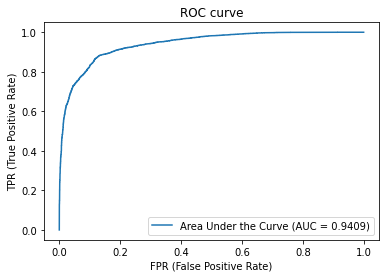

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)
AUC_ROC = roc_auc_score(y_true, y_score)
np.save("result/fpr.npy",fpr)
np.save("result/tpr.npy",tpr)
r =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")